In [1]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [2]:
#Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939] #Predefined BGR mean values for each layer used for normalization
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5  #Acc. to research paper the ratio of content_weight and style_weight should be between 10^-3 and 10^-4
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [3]:
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

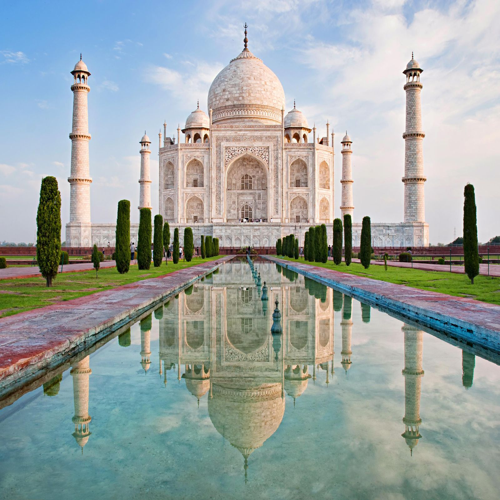

In [4]:
input_image= Image.open("taj_mahal.jpg")
input_image= input_image.resize((IMAGE_WIDTH,IMAGE_HEIGHT)) #resize takes size input as tuple(width,height)
input_image.save(input_image_path)
input_image

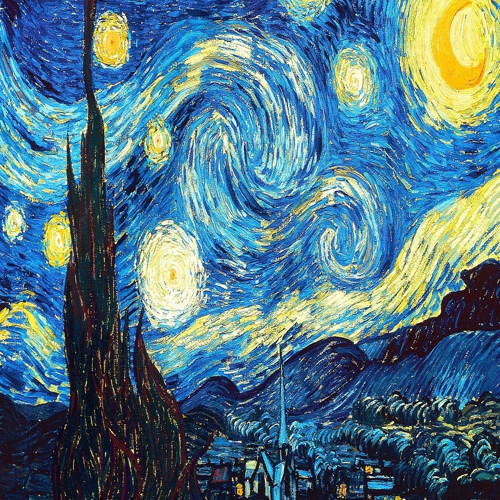

In [5]:
style_image= Image.open("starry_night.jpg")
style_image= style_image.resize((IMAGE_WIDTH,IMAGE_HEIGHT)) #resize takes size input as tuple(width,height)
style_image.save(style_image_path)
style_image

In [6]:
#normalization and reshaping image from RGB to BGR (VGG16 is trained on BGR so we need to convert image from RGB to BGR)
input_image_array=np.asarray(input_image,dtype='float32')
input_image_array=np.expand_dims(input_image_array,axis=0)
input_image_array[:,:,:,0]-=IMAGENET_MEAN_RGB_VALUES[2] #subtract mean value to normalize
input_image_array[:,:,:,1]-=IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:,:,:,2]-=IMAGENET_MEAN_RGB_VALUES[0]
input_image_array=input_image_array[:,:,:,::-1]#Reshape the array ftom RGB to BGR

style_image_array=np.asarray(style_image,dtype='float32')
style_image_array=np.expand_dims(style_image_array,axis=0)
style_image_array[:,:,:,0]-=IMAGENET_MEAN_RGB_VALUES[2] #subtract mean value to normalize
style_image_array[:,:,:,1]-=IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:,:,:,2]-=IMAGENET_MEAN_RGB_VALUES[0]
style_image_array=style_image_array[:,:,:,::-1]#Reshape the array ftom RGB to BGR

In [7]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

In [8]:
# define a function to find the content loss
def content_loss(content,combination):
    return backend.sum(backend.square(combination-content))
layers = dict([(layer.name,layer.output) for layer in model.layers])
content_layer = "block2_conv2" #Selected layer based on research paper
layers_features = layers[content_layer]
content_image_features = layers_features[0,:,:,:]
combination_features = layers_features[2,:,:,:]
loss = backend.variable(0.)
loss= loss + CONTENT_WEIGHT* content_loss(content_image_features,combination_features)

In [9]:
# We use gram matrix to find the correlations between filter responses
# Refer https://www.youtube.com/watch?v=k-nHMRs1ZWU to find relation between correlation and dot product. 
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

In [10]:
def compute_style_loss(style,combination):
    style=gram_matrix(style)
    combination=gram_matrix(combination)
    size=IMAGE_WIDTH*IMAGE_HEIGHT
    return backend.sum(backend.square(combination-style)/ (4 * (size**2) * (CHANNELS**2)))
                       
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"] # Based on research paper
                       
for layer_name in style_layers:
    layer_features= layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    style_loss= compute_style_loss(style_features,combination_features)
    loss=loss+ (STYLE_WEIGHT/len(style_layers))* style_loss # The len(style_layers) is the loss weight which is constant. 

In [11]:
# Variation loss is used to smoothen the pixilated output image or we can also use Avg.pool instead of Max pool
# VGG16 is based of Max pool, so to change it to Avg.pool it will be computationally expensive thus we prefer variation loss.
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [12]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 102294675456
Iteration 1 completed with loss 62391181312
Iteration 2 completed with loss 50588475392
Iteration 3 completed with loss 45222879232
Iteration 4 completed with loss 42432180224
Iteration 5 completed with loss 40872812544
Iteration 6 completed with loss 39747911680
Iteration 7 completed with loss 39069757440
Iteration 8 completed with loss 38608805888
Iteration 9 completed with loss 38278373376


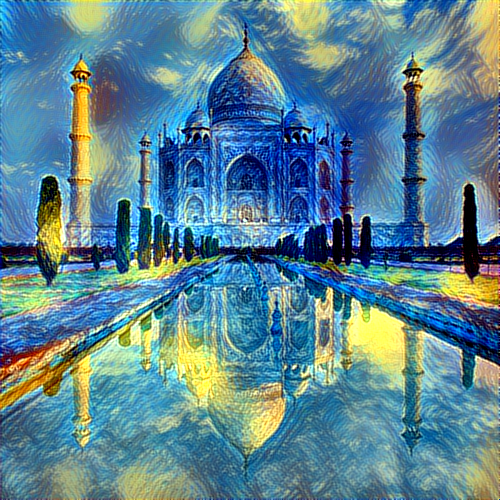

In [13]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128. #The combination image,initially initilized with random pixels.
# We subtract 128 to normalize the random image.
for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1] # To change the output BGR image to RGB format.
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

In [14]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined